# Python for AI Projects

## Introduction

**Natural Language Processing**

In this Jupyter notebook - we'll quickly setup our Python environment and get started with our Explore California NLP exercises.

### Challenge Exercises

1. Explore our `locations` NLP dataset
2. Implement keyword, TF-IDF and BM-25 search functionality
3. Create `BERT` sentence embeddings and implement semantic search
4. Setup simple Retrival-Augmented-Generation (RAG) AI workflow

We'll also cover how to use cloud-based LLMs to make **100% free** API calls to various LLMs using `OpenAI` and `OpenRouter`

### Getting Started

To execute each cell in this notebook - you can click on the play button on the left of each cell or hit `command/shift + enter` to run individual cells one-by-one.

In [ ]:
# Initial setup steps
# ====================

# Install Python libraries
!pip install --quiet rank_bm25==0.2.2
!pip install --quiet faiss-cpu==1.11.0
!pip install --quiet ctransformers==0.2.27
!pip install --quiet dotenv==0.9.9

# Clone GitHub repo into a "data" folder
!git clone https://github.com/datawithdanny/test-python-notebooks.git data

# Need to change directory into "data" to download git lfs data objects
%cd data
!git lfs pull

# Then we need to change directory back up so all our paths are correct
%cd ..

# Time to import all our Python packages
import os
import nltk
import pandas as pd
from pathlib import Path

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from rank_bm25 import BM25Okapi

nltk.download('punkt_tab')

# This is a convenience function to print long strings into multiple lines
# You'll see this in action later on in our tutorial!
def wrap_print(text):
    print(textwrap.fill(text, width=80))

# 1. Data Exploration

We'll begin by calculating the following using our `text_data` column from `locations_df` - this is the equivalent of the structured HTML data we'll extract from the webpage from the Explore California website.

* Total count of locations
* Vocabulary size and most frequent keywords
* Generate a word cloud for `text_data` and compare this with the simplified `description` field
* Create sentence embeddings and visualize clusters in 3D space to identify similar locations based off their `descriptions`

Let's first load in our `locations` datasets using Pandas and we'll get started by exploring our data.

## 1.1 Load Locations Data

In [1]:
# import pandas library
import pandas as pd

# Load in locations dataset
locations_df = pd.read_csv("data/locations.csv")

# View first few rows of dataframe
locations_df.head()

,location_id,location_name,category,latitude,longitude,region,area,description,text_data
0,1,Yosemite National Park,National & State Parks/Natural Wonders,37.865101,-119.538329,Yosemite Area,Sierra Nevada,Iconic national park known for its granite cli...,Yosemite National Park | Summary | Iconic nati...
1,2,Sequoia National Park,National & State Parks/Natural Wonders,36.4333166,-118.6836173,Sierra Nevada,Tulare County,"Home to giant sequoia trees, including the Gen...",Sequoia National Park | Summary | Home to gian...
2,3,Redwood National and State Parks,National & State Parks/Natural Wonders,41.364435,-124.004623,Northern California Coast,Humboldt & Del Norte Counties,"A string of protected forests, beaches and gra...",Redwood National and State Parks | Summary | A...
3,4,Joshua Tree National Park,National & State Parks/Natural Wonders,33.873415,-115.900992,Southern California Desert,Riverside & San Bernardino Counties,Characterized by rugged rock formations and st...,Joshua Tree National Park | Summary | Characte...
4,5,Death Valley National Park,National & State Parks/Natural Wonders,36.505402,-117.079408,Eastern California Desert,Inyo County,"The hottest, driest, and lowest national park,...",Death Valley National Park | Summary | The hot...


## 1.2 Locations Analysis

In [25]:
# How many unique locations are there?
print(f"There are {len(locations_df)} unique locations")

There are 236 unique locations


In [21]:
# Split the locations by region
locations_df["region"].value_counts()

region
Los Angeles               39
San Francisco             26
San Diego                 17
Various                    8
Sacramento                 6
                          ..
Huntington Beach           1
Laguna Beach               1
Carmel-by-the-Sea          1
San Mateo County Coast     1
Sonoma                     1
Name: count, Length: 94, dtype: int64

In [22]:
# Split the locations by category
locations_df["category"].value_counts()

category
Urban Attractions (Major Cities)          53
Beaches & Coastal Areas                   44
Museums & Cultural Attractions            36
National & State Parks/Natural Wonders    32
Historical Sites & Landmarks              32
Theme Parks & Entertainment               12
Islands                                   10
Outdoor Activities                         8
Wine Regions                               5
Road Trips                                 4
Name: count, dtype: int64

## 1.3 NLP Analysis

### 1.3.1 Most Frequent Terms

> Identify the top 25 most frequent terms across all locations

In [ ]:
# ---------------------------------------
# Goal: Identify the Top 25 Most Frequent Terms Across All Locations
# ---------------------------------------

from sklearn.feature_extraction.text import CountVectorizer  # Used for tokenizing and counting word frequencies

# ---------------------------------------
# Step 1: Initialize CountVectorizer
# ---------------------------------------
# We use uni-gram tokenization (single words) and automatically remove common English stopwords
# This helps us focus on meaningful content-specific terms
vectorizer = CountVectorizer(stop_words="english")

# ---------------------------------------
# Step 2: Fit the vectorizer to the text data
# ---------------------------------------
# The input is a list of raw text strings from the 'text_data' column (assumed to be pre-cleaned)
# This will tokenize each document and build a term-document matrix
X = vectorizer.fit_transform(locations_df['text_data'])

# ---------------------------------------
# Step 3: Aggregate total term frequencies across all documents
# ---------------------------------------
# Get the list of all terms (vocabulary)
terms = vectorizer.get_feature_names_out()

# Sum up the count of each term across all documents
term_counts = X.toarray().sum(axis=0)

# Create a DataFrame showing each term and its total count
word_freq = pd.DataFrame({
    'term': terms,
    'count': term_counts
})

# Sort terms by descending frequency
word_freq = word_freq.sort_values(by="count", ascending=False)

# ---------------------------------------
# Step 4: Output results
# ---------------------------------------
print(f"Total number of unique uni-gram terms: {len(word_freq)}")

# Display the top 25 most frequent terms
word_freq.head(25)


Total number of uni-gram terms: 1990


,term,count
1926,visitor,611
1558,region,480
1436,peak,475
1343,nearby,474
468,advance,472
520,arrive,472
754,conditions,447
699,check,445
685,center,392
1646,scenic,348


### 1.3.2 Word Cloud Visualization

We'll use our HTML `text_data` and the summary `description` data to build 2 word clouds and compare them side-by-side.

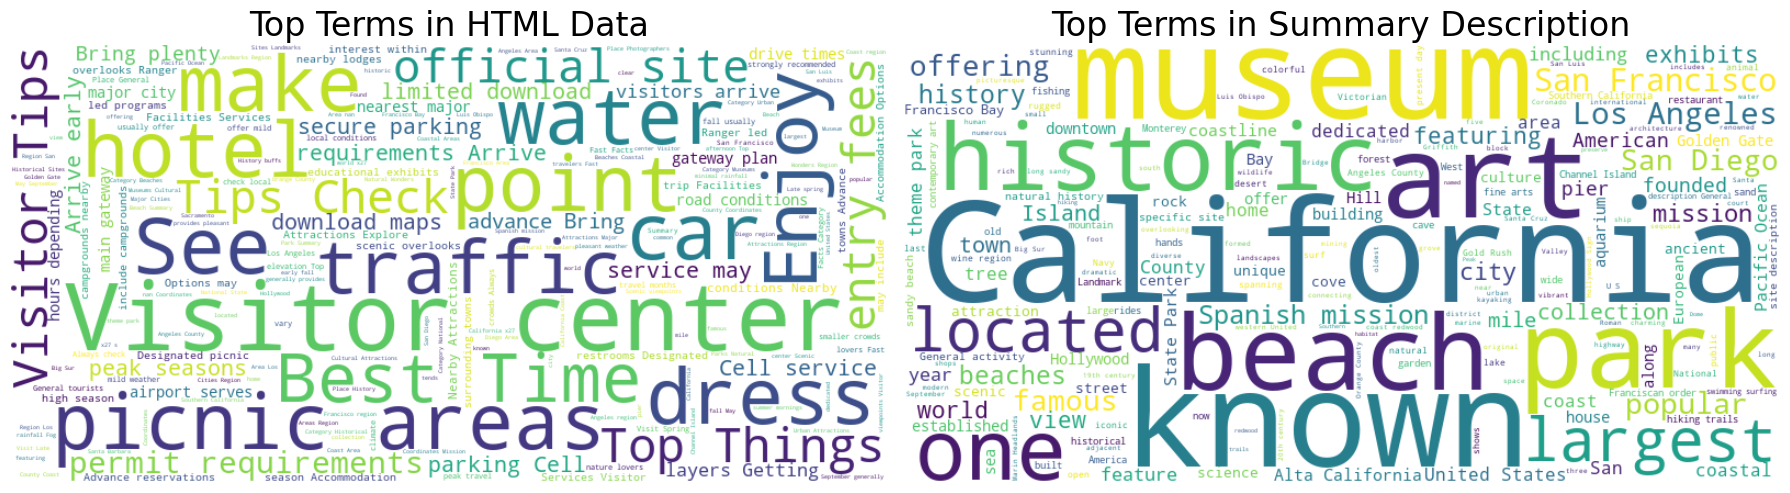

In [27]:
# ---------------------------------------
# Goal: Compare Frequent Terms in 'text_data' vs 'description' Using Side-by-Side Word Clouds
# ---------------------------------------

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# ---------------------------------------
# Step 1: Prepare text inputs
# ---------------------------------------
wordcloud_text_inputs = " ".join(locations_df['text_data'])
wordcloud_description_inputs = " ".join(locations_df['description'])

# ---------------------------------------
# Step 2: Generate WordClouds
# ---------------------------------------
wordcloud_text = WordCloud(
    width=800, height=400, background_color='white'
).generate(wordcloud_text_inputs)

wordcloud_description = WordCloud(
    width=800, height=400, background_color='white'
).generate(wordcloud_description_inputs)

# ---------------------------------------
# Step 3: Plot the WordClouds side-by-side
# ---------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(18, 8))  # Create 1 row, 2 column layout

# Left: WordCloud for HTML text_data
axes[0].imshow(wordcloud_text, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title("Top Terms in HTML Data", fontsize=24)

# Right: WordCloud for description
axes[1].imshow(wordcloud_description, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title("Top Terms in Summary Description", fontsize=24)

plt.tight_layout()
plt.show()


### 1.3.2 Sentence Embeddings

In this final exploration exercise - we'll use a light sentence transformer model to encode our summary `description` data as embeddings.

Embeddings is a term that gets used quite a lot in machine learning and AI so it's useful to understand how it works from a basic perspective.

In [ ]:
# Import necessary libraries
from sentence_transformers import SentenceTransformer  # For encoding text into embeddings
from sklearn.cluster import KMeans                     # For unsupervised clustering
from sklearn.manifold import TSNE                      # For dimensionality reduction to 3D
import plotly.express as px                            # For interactive 3D plotting

# ---------------------------------------
# Step 1: Encode location descriptions into embeddings
# ---------------------------------------
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')  # Load a pre-trained lightweight sentence embedding model
embeddings = embedding_model.encode(locations_df['description'].tolist())  # Generate embeddings for each description

# ---------------------------------------
# Step 2: Cluster embeddings into semantic groups
# ---------------------------------------
kmeans = KMeans(n_clusters=5, random_state=42)  # Define k-means clustering with 5 clusters
clusters = kmeans.fit_predict(embeddings)       # Assign each embedding to a cluster

# ---------------------------------------
# Step 3: Reduce high-dimensional embeddings to 3D for visualization
# ---------------------------------------
tsne = TSNE(n_components=3, random_state=42)     # Initialize t-SNE for 3D projection
embedding_3d = tsne.fit_transform(embeddings)    # Perform dimensionality reduction

# ---------------------------------------
# Step 4: Prepare the DataFrame for plotting
# ---------------------------------------
locations_plotting_df = locations_df.loc[:, ["location_name", "description"]]  # Select relevant columns

# Create a shortened version of the description for tooltips (first 25 characters + ellipsis)
locations_plotting_df["short_description"] = locations_plotting_df['description'].str[:25] + '...'

# Add clustering and 3D coordinates to the plotting DataFrame
locations_plotting_df['cluster'] = clusters
locations_plotting_df['x'] = embedding_3d[:, 0]
locations_plotting_df['y'] = embedding_3d[:, 1]
locations_plotting_df['z'] = embedding_3d[:, 2]

# ---------------------------------------
# Step 5: Create an interactive 3D scatter plot
# ---------------------------------------
fig = px.scatter_3d(
    locations_plotting_df,
    x='x', y='y', z='z',              # 3D coordinates from t-SNE
    color='cluster',                 # Color by assigned cluster
    hover_data={                     # Customize tooltip content
        'location_name': True,
        'short_description': True,
        'x': False, 'y': False, 'z': False  # Hide raw coordinates in tooltip
    },
    title="Embedding Location Descriptions",
    labels={'x': 't-SNE X', 'y': 't-SNE Y'}  # Axis labels
)

# ---------------------------------------
# Step 6: Customize figure appearance
# ---------------------------------------
fig.update_layout(
    width=1000, height=1000,                   # Set plot size
    margin=dict(l=0, r=0, b=0, t=40)           # Adjust margins for cleaner layout
)

fig.update_traces(marker=dict(size=8, opacity=0.7))  # Tune marker size and transparency

# ---------------------------------------
# Step 7: Show the interactive plot
# ---------------------------------------
fig.show()


/Users/dannyma/Code/linkedin-learning/applied-AI-and-machine-learning-for-data-practitioners-5932259/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1762: FutureWarning:

`encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.



## 

In [17]:
embeddings

array([[ 0.07693794,  0.04677289,  0.07296745, ..., -0.02717057,
        -0.01258301, -0.04360675],
       [ 0.01864855,  0.01192206, -0.00707836, ..., -0.0590596 ,
         0.01419835,  0.06414233],
       [ 0.11244677,  0.01562865,  0.01066415, ..., -0.13283658,
         0.07591438,  0.09993519],
       ...,
       [-0.02095913,  0.03698168, -0.05700795, ...,  0.00217744,
         0.05586077,  0.07934482],
       [ 0.05439383,  0.01761532, -0.0328052 , ...,  0.01689355,
        -0.01897334,  0.06093495],
       [ 0.12145292,  0.0075028 , -0.03359886, ...,  0.02514214,
        -0.02391355,  0.09232495]], shape=(236, 384), dtype=float32)

In [16]:
locations_plotting_df.head()

,location_name,description,short_description,cluster,x,y,z
0,Yosemite National Park,Iconic national park known for its granite cli...,Iconic national park know...,2,-0.132505,28.127859,-46.446812
1,Sequoia National Park,"Home to giant sequoia trees, including the Gen...",Home to giant sequoia tre...,2,15.680990,34.322956,-19.441639
2,Redwood National and State Parks,"A string of protected forests, beaches and gra...",A string of protected for...,2,2.928319,38.677628,-18.561558
3,Joshua Tree National Park,Characterized by rugged rock formations and st...,Characterized by rugged r...,2,18.670128,14.658884,-52.885845
4,Death Valley National Park,"The hottest, driest, and lowest national park,...","The hottest, driest, and ...",2,4.032790,19.492662,-54.757675


## Setup Cloud LLMs API Keys

In the cell below - please add your `Open AI` and `OpenRouter` API keys to make inference calls to our cloud based LLMs.

Open AI has a free $5-10 trial available for new users and OpenRouter has a limit of 50 API calls per day which should be more than enough for our initial testing purposes!

> **Warning 🚨🚨🚨** Make sure to never share your API keys and be careful to expose them to the public!

In [ ]:
%%writefile .env
OPEN_AI_API_KEY=UPDATE-YOUR-API-KEY-HERE
OPEN_ROUTER_API_KEY=UPDATE-YOUR-API-KEY-HERE

In [ ]:
from dotenv import load_dotenv

# Load the .env file
load_dotenv()

# Save the token as local variable
open_ai_api_key = os.getenv("OPEN_AI_API_KEY")
print("Open AI API key loaded:", open_ai_api_key[:8] + "...")

In [ ]:
# Delete the .env file
if os.path.exists(".env"):
    os.remove(".env")
    print("✅ .env file removed safely.")